In [40]:
import glob
import json
import pandas as pd
import os
import json
from dotenv import load_dotenv


import openai
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


load_dotenv("api.env")
api_key = os.environ.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

# 你的API密钥
openai.api_key = api_key


In [41]:
import json

def read_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data


In [89]:
import os
import json
import pandas as pd

def extract_properties_to_wide_format(data):
    rows = []
    
    for entry in data['materials']:
        name = entry['material_name']
        benchmark = entry['benchmark']
        feature_sets = []
        unique_features = set()
        
        for prop in entry['properties']:
            feature_name = prop['type']
            value = prop['value']
            unit = prop['unit']
            combined_value_unit = f"{value} {unit}"
            condition = prop['conditions']
            reaction_type = prop.get('reaction_type', 'NA')
            
            # Check for specific reaction types and modify feature_name
            if reaction_type in ['ORR', 'OER', 'HER']:
                feature_name = f"{feature_name}_{reaction_type}"
            
            if feature_name in unique_features:
                features = {
                    feature_name: combined_value_unit,
                    f"{feature_name}_condition": condition,
                    'material_name': name,
                    'benchmark': benchmark
                }
                feature_sets.append(features)
            else:
                features = {
                    feature_name: combined_value_unit,
                    f"{feature_name}_condition": condition
                }
                unique_features.add(feature_name)
                feature_sets.append(features)
        
        for features in feature_sets:
            if 'material_name' not in features:
                features['material_name'] = name
            if 'benchmark' not in features:
                features['benchmark'] = benchmark
            rows.append(features)
    
    return pd.DataFrame(rows)

def load_and_process_json_files(folder_path):
    all_dataframes = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as f:
                data = json.load(f)
                df = extract_properties_to_wide_format(data)
                all_dataframes.append(df)
    
    # 使用 outer 合并所有数据框，以保留所有列
    combined_df = pd.concat(all_dataframes, ignore_index=True, sort=False).fillna('None')
    
    return combined_df

# 更新文件夹路径
folder_path = '/Users/yangz/Documents/projects/llm4catalyst/results/test'  # 替换为你的实际文件夹路径
combined_df = load_and_process_json_files(folder_path)

# rearrange columns
df = combined_df[['material_name', 'benchmark'] + sorted(combined_df.columns.difference(['material_name', 'benchmark']))]

print(df)


     material_name  benchmark N/C atomic ratio N/C atomic ratio_condition  \
0            SWCNT      False             None                       None   
1            SWCNT      False             None                       None   
2              C60      False             None                       None   
3        C60-SWCNT      False             None                       None   
4        C60-SWCNT      False             None                       None   
..             ...        ...              ...                        ...   
69  N-GQD/graphene      False             None                       None   
70  N-GQD/graphene      False             None                       None   
71  N-GQD/graphene      False             None                       None   
72            Pt/C       True             None                       None   
73            Pt/C       True             None                       None   

   O/C atomic ratio O/C atomic ratio_condition OER activity_OER  \
0       

In [86]:

# 需要生成嵌入的条件列
condition_columns = [col for col in df.columns if col.endswith('_condition')]

# 函数：生成文本嵌入
def generate_embeddings(text):
    if text is None or pd.isna(text):
        return [0] * 768  # 对于None值，用全零向量表示
    response = openai.Embedding.create(input=text, model="text-embedding-ada-002")
    return response['data'][0]['embedding']

# 确保所有嵌入的维度一致
def pad_embeddings(embedding, target_length):
    if len(embedding) < target_length:
        embedding = embedding + [0] * (target_length - len(embedding))
    return embedding

# 对每个条件列生成嵌入
embeddings = []
max_length = 0

for column in condition_columns:
    df[f"{column}_embedding"] = df[column].apply(generate_embeddings)
    # 找到最大嵌入长度
    max_length = max(max_length, max(df[f"{column}_embedding"].apply(len)))

for column in condition_columns:
    df[f"{column}_embedding"] = df[f"{column}_embedding"].apply(lambda x: pad_embeddings(x, max_length))
    embeddings.append(np.vstack(df[f"{column}_embedding"].values))

# 将所有嵌入拼接在一起
embeddings = np.hstack(embeddings)

/var/folders/z8/zm1gct552gb8700n_kq3pm9h0000gn/T/ipykernel_59132/3266207183.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column}_embedding"] = df[column].apply(generate_embeddings)
/var/folders/z8/zm1gct552gb8700n_kq3pm9h0000gn/T/ipykernel_59132/3266207183.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column}_embedding"] = df[column].apply(generate_embeddings)
/var/folders/z8/zm1gct552gb8700n_kq3pm9h0000gn/T/ipykernel_59132/3266207183.py:23: SettingWithCopyWarning: 
A value is try

/Users/yangz/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/yangz/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


IndexError: index 74 is out of bounds for axis 0 with size 74

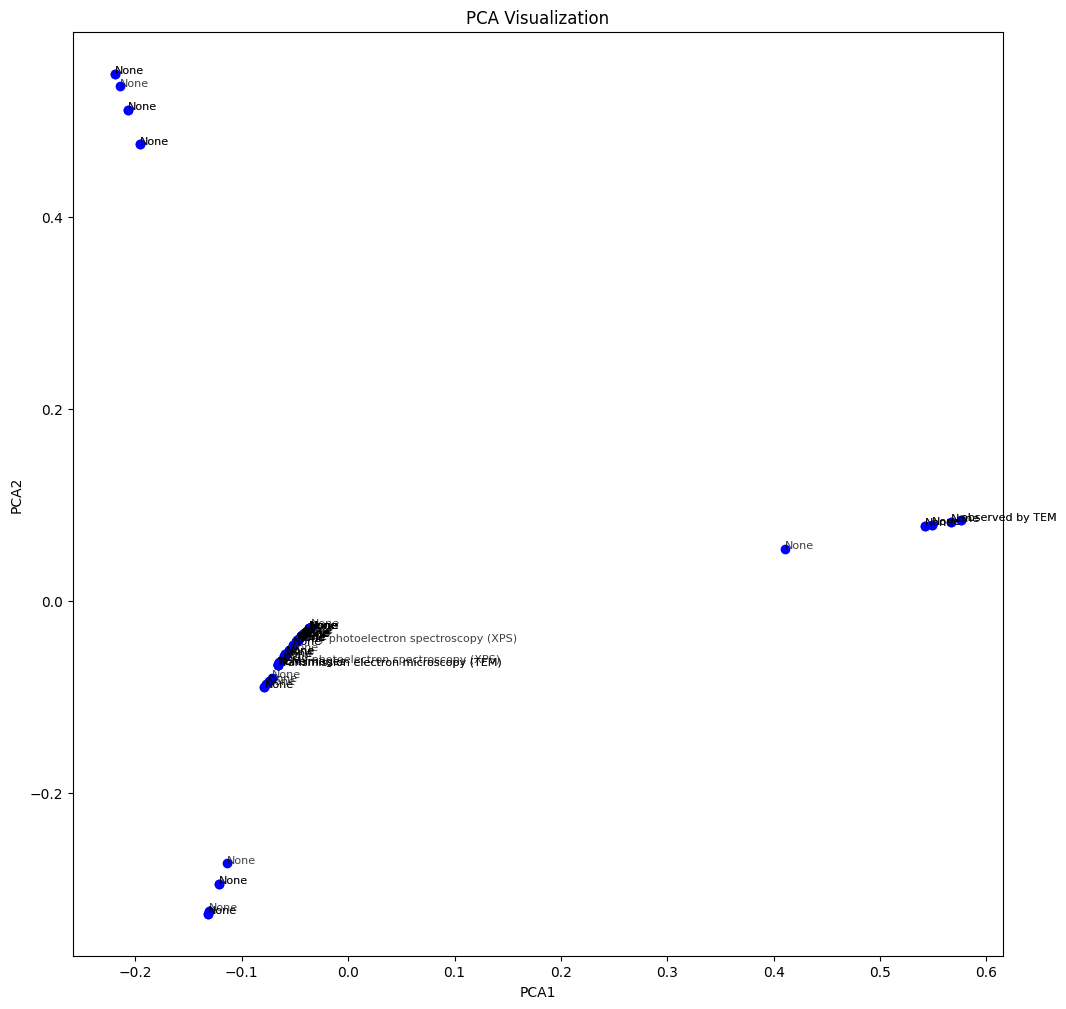

In [88]:

# 使用PCA进行降维
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, perplexity=5)
tsne_result = tsne.fit_transform(embeddings)

# 可视化PCA结果
plt.figure(figsize=(12, 12))  # 设置图像大小

plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue')
plt.title('PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

for i, text in enumerate(all_conditions):
    plt.annotate(text, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.75)

plt.show()

# 可视化t-SNE结果
plt.figure(figsize=(12, 12))  # 设置图像大小

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='red')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

for i, text in enumerate(all_conditions):
    plt.annotate(text, (tsne_result[i, 0], tsne_result[i, 1]), fontsize=8, alpha=0.75)

plt.show()

# end


In [83]:
combined_df

,material_name,benchmark,N/C atomic ratio,N/C atomic ratio_condition,O/C atomic ratio,O/C atomic ratio_condition,OER activity_OER,OER activity_OER_condition,Tafel slope_HER,Tafel slope_HER_condition,...,oxygen reduction peak_ORR,oxygen reduction peak_ORR_condition,performance decrease_HER,performance decrease_HER_condition,reduction peak_ORR,reduction peak_ORR_condition,topographic height,topographic height_condition,ΔE_OER,ΔE_OER_condition
0,SWCNT,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,SWCNT,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,C60,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,C60-SWCNT,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,C60-SWCNT,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,N-GQD/graphene,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
70,N-GQD/graphene,False,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
71,N-GQD/graphene,False,None,None,None,None,None,None,None,None,...,None,None,None,None,-0.27 V,O2-saturated KOH solution,None,None,None,None
72,Pt/C,True,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


{'materials': [{'material_name': 'N-GQDs', 'properties': [{'type': 'diameter', 'associated_factor': 'dimension or size', 'value': 2.0, 'unit': 'nm', 'conditions': 'observed by TEM', 'reaction_type': 'NA', 'evidence': 0}, {'type': 'diameter', 'associated_factor': 'dimension or size', 'value': 5.0, 'unit': 'nm', 'conditions': 'observed by TEM', 'reaction_type': 'NA', 'evidence': 0}, {'type': 'diameter', 'associated_factor': 'dimension or size', 'value': 2.0, 'unit': 'nm', 'conditions': 'Transmission electron microscopy (TEM)', 'reaction_type': 'NA', 'evidence': 1}, {'type': 'diameter', 'associated_factor': 'dimension or size', 'value': 5.0, 'unit': 'nm', 'conditions': 'Transmission electron microscopy (TEM)', 'reaction_type': 'NA', 'evidence': 1}, {'type': 'topographic height', 'associated_factor': 'dimension or size', 'value': 1.0, 'unit': 'nm', 'conditions': 'Atomic force microscopy (AFM)', 'reaction_type': 'NA', 'evidence': 1}, {'type': 'topographic height', 'associated_factor': 'dime

In [43]:
import re
def extract_properties_to_wide_format(data):
    rows = []
    
    for entry in data['materials']:
        name = entry['material_name']
        benchmark = entry['benchmark']
        feature_sets = []
        unique_features = set()
        
        for prop in entry['properties']:
            feature_name = prop['type']
            value = prop['value']
            unit = prop['unit']
            combined_value_unit = f"{value} {unit}"
            condition = prop['conditions']
            reaction_type = prop.get('reaction_type', 'NA')
            
            # Check for specific reaction types and modify feature_name
            if reaction_type in ['ORR', 'OER', 'HER']:
                feature_name = f"{feature_name}_{reaction_type}"
            
            if feature_name in unique_features:
                features = {
                    feature_name: combined_value_unit,
                    f"{feature_name}_condition": condition,
                    'material_name': name,
                    'benchmark': benchmark
                }
                feature_sets.append(features)
            else:
                features = {
                    feature_name: combined_value_unit,
                    f"{feature_name}_condition": condition
                }
                unique_features.add(feature_name)
                feature_sets.append(features)
        
        for features in feature_sets:
            if 'material_name' not in features:
                features['material_name'] = name
            if 'benchmark' not in features:
                features['benchmark'] = benchmark
            rows.append(features)
    
    return pd.DataFrame(rows)

df = extract_properties_to_wide_format(data)
# rearrange columns
df = df[['material_name', 'benchmark'] + sorted(df.columns.difference(['material_name', 'benchmark']))]
df

,material_name,benchmark,N/C atomic ratio,N/C atomic ratio_condition,O/C atomic ratio,O/C atomic ratio_condition,conductivity,conductivity_condition,diameter,diameter_condition,interlayer spacing,interlayer spacing_condition,onset potential_ORR,onset potential_ORR_condition,reduction peak_ORR,reduction peak_ORR_condition,topographic height,topographic height_condition
0,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,2.0 nm,observed by TEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,5.0 nm,observed by TEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,2.0 nm,Transmission electron microscopy (TEM),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,5.0 nm,Transmission electron microscopy (TEM),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0 nm,Atomic force microscopy (AFM)
5,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5 nm,Atomic force microscopy (AFM)
6,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34 nm,High-resolution TEM,NaN,NaN,NaN,NaN,NaN,NaN
7,N-GQDs,False,4.28 %,X-ray photoelectron spectroscopy (XPS),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,N-GQDs,False,NaN,NaN,27.0 %,X-ray photoelectron spectroscopy (XPS),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,2.0 nm,TEM images,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:

# 需要生成嵌入的条件列
condition_columns = [col for col in df.columns if col.endswith('_condition')]

# 函数：生成文本嵌入
def generate_embeddings(text):
    if text is None or pd.isna(text):
        return [0] * 768  # 对于None值，用全零向量表示
    response = openai.Embedding.create(input=text, model="text-embedding-ada-002")
    return response['data'][0]['embedding']

# 确保所有嵌入的维度一致
def pad_embeddings(embedding, target_length):
    if len(embedding) < target_length:
        embedding = embedding + [0] * (target_length - len(embedding))
    return embedding

# 对每个条件列生成嵌入
embeddings = []
max_length = 0

for column in condition_columns:
    df[f"{column}_embedding"] = df[column].apply(generate_embeddings)
    # 找到最大嵌入长度
    max_length = max(max_length, max(df[f"{column}_embedding"].apply(len)))

for column in condition_columns:
    df[f"{column}_embedding"] = df[f"{column}_embedding"].apply(lambda x: pad_embeddings(x, max_length))
    embeddings.append(np.vstack(df[f"{column}_embedding"].values))

# 将所有嵌入拼接在一起
embeddings = np.hstack(embeddings)

In [76]:
df.head()

,material_name,benchmark,N/C atomic ratio,N/C atomic ratio_condition,O/C atomic ratio,O/C atomic ratio_condition,conductivity,conductivity_condition,diameter,diameter_condition,...,topographic height,topographic height_condition,N/C atomic ratio_condition_embedding,O/C atomic ratio_condition_embedding,conductivity_condition_embedding,diameter_condition_embedding,interlayer spacing_condition_embedding,onset potential_ORR_condition_embedding,reduction peak_ORR_condition_embedding,topographic height_condition_embedding
0,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,2.0 nm,observed by TEM,...,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.024426676332950592, -0.013213885016739368,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,5.0 nm,observed by TEM,...,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.024426676332950592, -0.013213885016739368,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,2.0 nm,Transmission electron microscopy (TEM),...,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.022287284955382347, -0.0123325539752841, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,5.0 nm,Transmission electron microscopy (TEM),...,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.022287284955382347, -0.0123325539752841, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,N-GQDs,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0 nm,Atomic force microscopy (AFM),"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.037194982171058655, -0.009430923499166965,..."


/Users/yangz/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/yangz/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


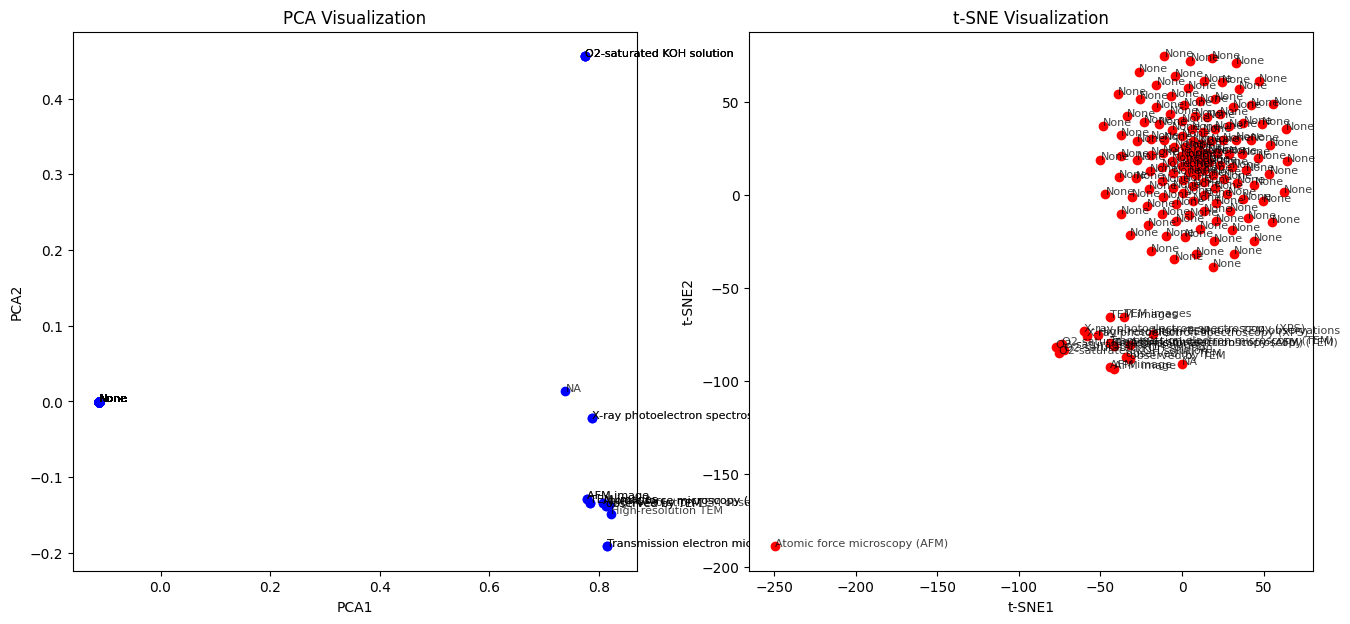

In [78]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 df 已经包含了嵌入向量和对应的条件列
# 这里的 df 是你的数据框
# df = pd.read_csv("/mnt/data/your_data.csv")  # 更新路径为实际数据文件路径

# 提取所有的 _embedding 列和对应的 _condition 列
embedding_columns = [col for col in df.columns if col.endswith('_embedding')]
condition_columns = [col.replace('_embedding', '') for col in embedding_columns]

# 收集所有的嵌入向量和对应的条件值
all_embeddings = []
all_conditions = []

for embedding_col, condition_col in zip(embedding_columns, condition_columns):
    # 检查嵌入向量列是否为字符串形式，如果是则使用 eval()，否则直接使用
    if isinstance(df[embedding_col].iloc[0], str):
        embeddings = df[embedding_col].apply(eval).tolist()  # 确保将字符串转换为列表
    else:
        embeddings = df[embedding_col].tolist()
        
    conditions = df[condition_col].fillna('None').tolist()
    all_embeddings.extend(embeddings)
    all_conditions.extend(conditions)

# 转换为NumPy数组
embeddings = np.array(all_embeddings)

/Users/yangz/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/yangz/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


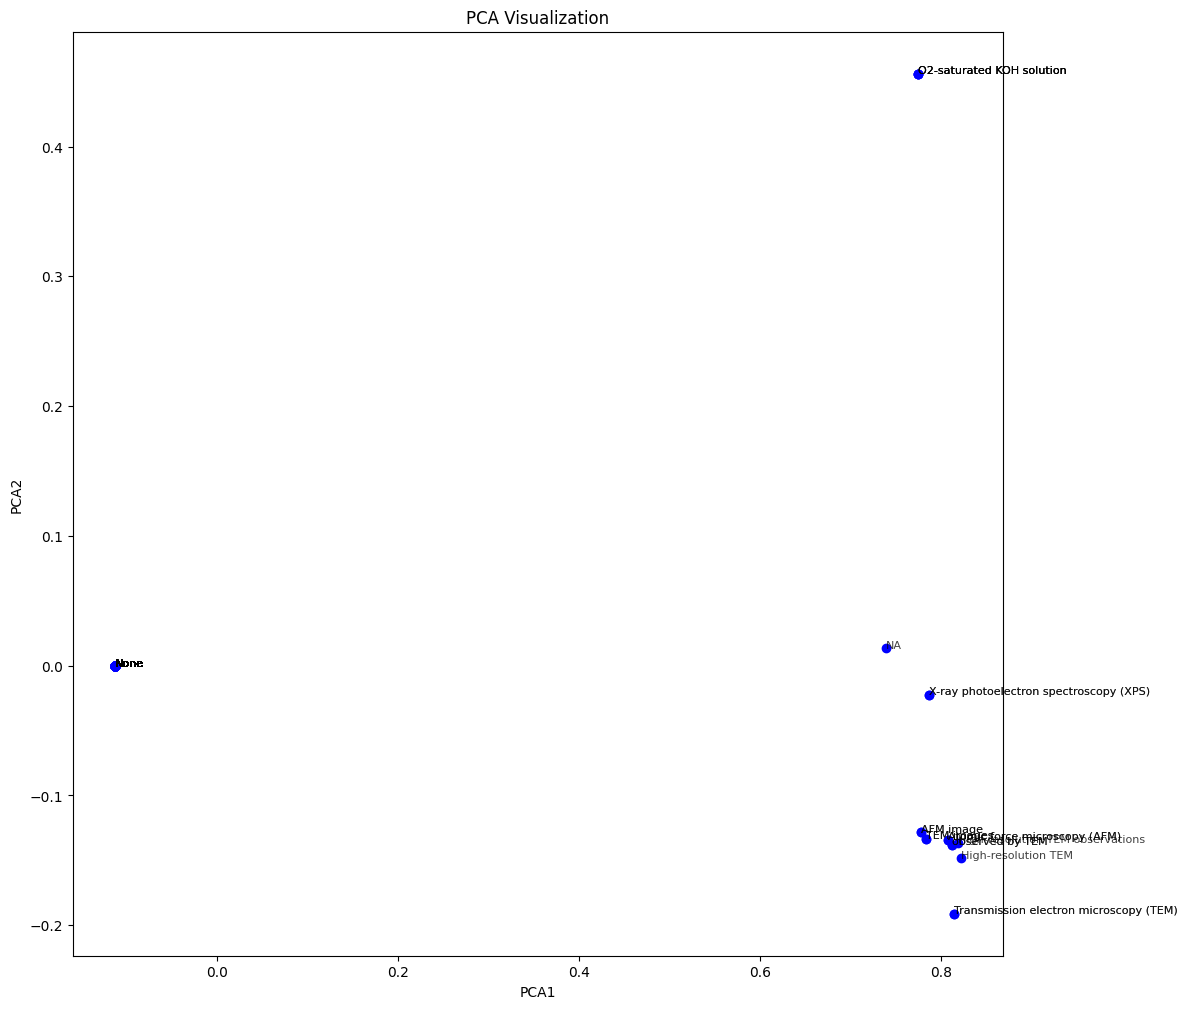

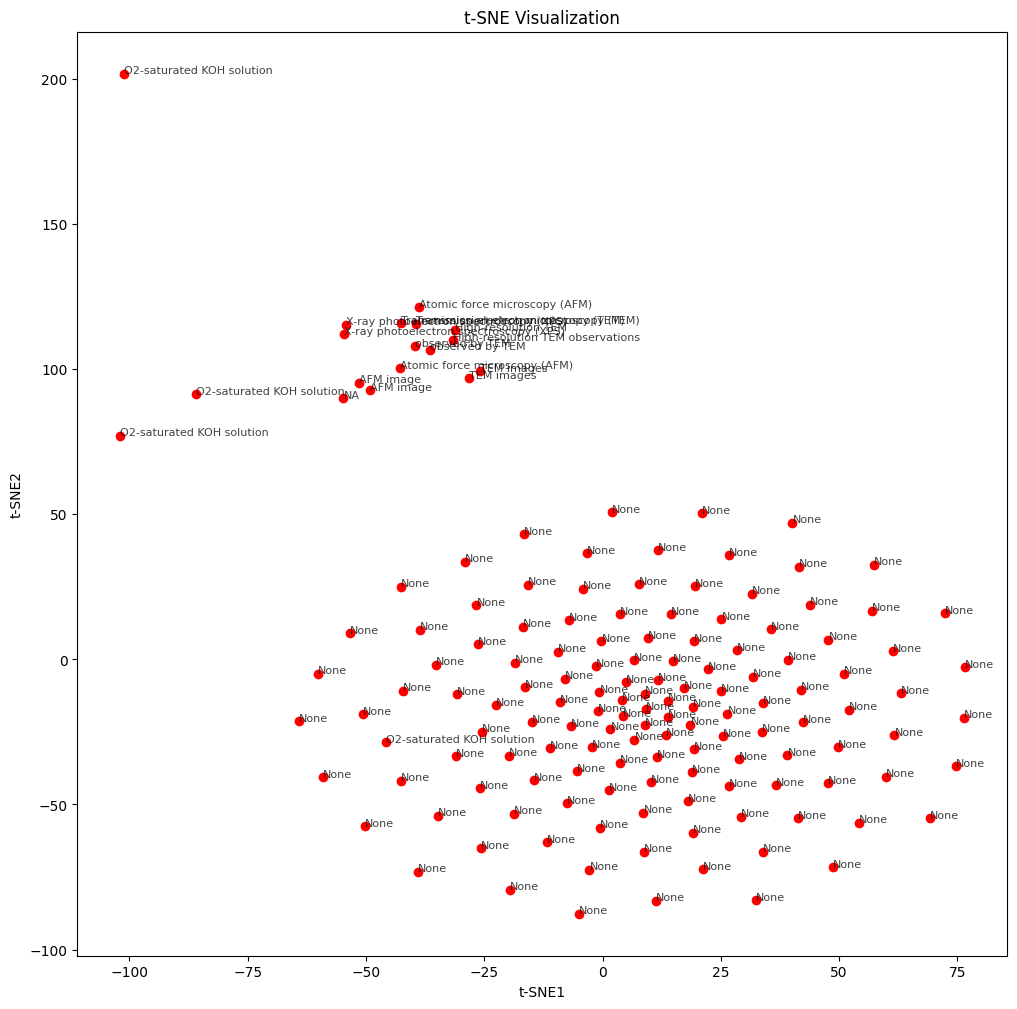

In [79]:

# 使用PCA进行降维
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, perplexity=5)
tsne_result = tsne.fit_transform(embeddings)

# 可视化PCA结果
plt.figure(figsize=(12, 12))  # 设置图像大小

plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue')
plt.title('PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

for i, text in enumerate(all_conditions):
    plt.annotate(text, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.75)

plt.show()

# 可视化t-SNE结果
plt.figure(figsize=(12, 12))  # 设置图像大小

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='red')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

for i, text in enumerate(all_conditions):
    plt.annotate(text, (tsne_result[i, 0], tsne_result[i, 1]), fontsize=8, alpha=0.75)

plt.show()

In [ ]:

# 对每个条件列生成嵌入并收集所有嵌入向量
all_embeddings = []
all_texts = []

for column in condition_columns:
    embedding_col = f"{column}_embedding"
    df[embedding_col] = df[column].apply(generate_embeddings)
    embeddings = df[embedding_col].tolist()
    texts = df[column].fillna('None').tolist()
    all_embeddings.extend(embeddings)
    all_texts.extend(texts)


In [74]:
all_embeddings

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [ ]:

# 转换为NumPy数组
embeddings = np.array(all_embeddings)

# 使用PCA进行降维
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, perplexity=5)
tsne_result = tsne.fit_transform(embeddings)

# 可视化PCA结果
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue')
plt.title('PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

for i, text in enumerate(all_texts):
    plt.annotate(text, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.75)

# 可视化t-SNE结果
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='red')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

for i, text in enumerate(all_texts):
    plt.annotate(text, (tsne_result[i, 0], tsne_result[i, 1]), fontsize=8, alpha=0.75)

plt.show()